In [1]:
import pandas as pd
import pandahouse
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch



In [19]:
q = """
SELECT exp_group, 
       user_id,
       countIf(action = 'like') as likes,
       countIf(action = 'view') as views,
       likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
        and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


In [20]:
df = Getch(q, db='simulator_20220620').df
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
5,2,131473,14,134,0.104478
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,26,128,0.203125
9,2,24239,40,90,0.444444


In [21]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


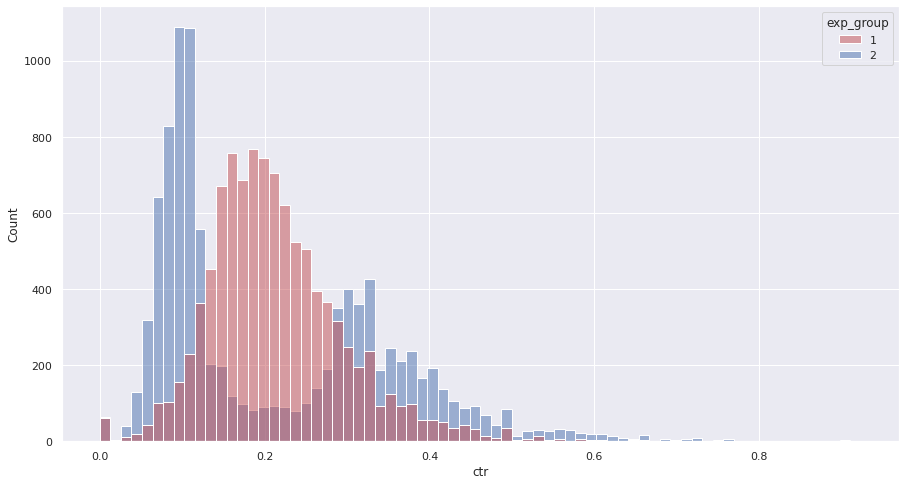

In [17]:
sns.set()
plt.figure(figsize = (15,8))
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### T-TEST

In [18]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

**Результаты t-теста не дают нам опровергнуть гипотезу, что средние равны. Однако график дает нам повод сомневаться в корректности теста.**

### MW-TEST

In [23]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

**Значение p-value дает нам возможность опровергнуть нулевую гипотезу**

### POISSON BOOSTRAP

In [31]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [32]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [33]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

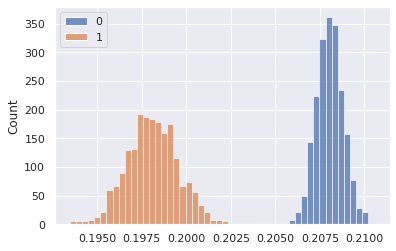

In [40]:
sns.histplot([ctr1, ctr2], bins=50)

**CTR контрольной группы больше**

**Вывод: Сравнив результаты Т-теста, МУ-теста и пуассоновского бутстрепа, можно сделать определенные выводы. Большая часть тестовой группы выдаёт худший CTR - но есть подгруппа с улучшением. На неё явно стоит обратить внимание и провести дополнительные исследования.